In [1]:
%matplotlib inline

In [2]:
import numpy as np

from nengolib import Lowpass

from nengo.builder import Builder, Operator, Signal
from nengo.builder.operator import Reset
from nengo.learning_rules import LearningRuleType
from nengo.params import NumberParam, Default
from nengo.synapses import SynapseParam


class RLS(LearningRuleType):

    modifies = 'decoders'
    probeable = ('pre_filtered', 'error', 'delta', 'inv_gamma')

    pre_synapse = SynapseParam(
        'pre_synapse', readonly=True)

    def __init__(self, learning_rate=1.0, pre_synapse=Lowpass(tau=0.005)):
        super(RLS, self).__init__(learning_rate, size_in='post_state')
        self.pre_synapse = pre_synapse

    @property
    def _argreprs(self):
        args = []
        if self.learning_rate != 1.0:
            args.append("learning_rate=%g" % self.learning_rate)
        if self.pre_synapse is not None and self.pre_synapse != Lowpass(tau=0.005):
            args.append("pre_synapse=%r" % self.pre_synapse)
        return args


def build_or_passthrough(model, obj, signal):
    """Builds the obj on signal, or returns the signal if obj is None."""
    if obj is not None:
        signal = model.build(obj, signal)
    return signal


class SimRLS(Operator):

    def __init__(self, pre_filtered, error, delta, inv_gamma, tag=None):
        super(SimRLS, self).__init__(tag=tag)

        self.sets = []
        self.incs = []
        self.reads = [pre_filtered, error]
        self.updates = [delta, inv_gamma]

    @property
    def delta(self):
        return self.updates[0]

    @property
    def inv_gamma(self):
        return self.updates[1]

    @property
    def pre_filtered(self):
        return self.reads[0]

    @property
    def error(self):
        return self.reads[1]
    
    def _descstr(self):
        return 'pre=%s > %s' % (self.pre_filtered, self.delta)

    def make_step(self, signals, dt, rng):
        r = signals[self.pre_filtered]
        delta = signals[self.delta]
        error = signals[self.error]
        P = signals[self.inv_gamma]
        
        def step_simbcm():
            # Note: dt is not used in learning rule
            rP = r.T.dot(P)
            P[...] -= P.dot(np.outer(r, rP)) / (1 + rP.dot(r))
            delta[...] = - error * P.dot(r)
        return step_simbcm


@Builder.register(RLS)
def build_rls(model, rls, rule):
    conn = rule.connection
    pre_activities = model.sig[conn.pre_obj]['out']
    
    pre_filtered = (pre_activities
                    if rls.pre_synapse is None
                    else model.build(rls.pre_synapse, pre_activities))

    # Create input error signal
    error = Signal(np.zeros(rule.size_in), name="RLS:error")
    model.add_op(Reset(error))
    model.sig[rule]['in'] = error
    
    # Create signal for running estimate of inverse correlation matrix
    assert pre_filtered.ndim == 1
    n_neurons = pre_filtered.shape[0]
    inv_gamma = Signal(np.eye(n_neurons) * rls.learning_rate, name="RLS:inv_gamma")
    
    model.add_op(SimRLS(pre_filtered=pre_filtered,
                        error=error,
                        delta=model.sig[rule]['delta'],
                        inv_gamma=inv_gamma))

    # expose these for probes
    model.sig[rule]['pre_filtered'] = pre_filtered
    model.sig[rule]['error'] = error
    model.sig[rule]['inv_gamma'] = inv_gamma

In [3]:
import nengo

T = 2.0
tau = 0.005

with nengo.Network() as model:
    
    u = nengo.Node(output=lambda t: np.sin(2*np.pi*t))
    
    x = nengo.Ensemble(100, 1, neuron_type=nengo.LIF())
    y = nengo.Node(size_in=1)
    
    e = nengo.Node(size_in=1, output=lambda t, x: x if t < T/2 else 0)
    
    nengo.Connection(u, x, synapse=None)
    conn = nengo.Connection(
        x, y, function=lambda _: 0, synapse=None,
        learning_rule_type=RLS(learning_rate=1e-5, pre_synapse=tau))
        
    nengo.Connection(y, e, synapse=None)
    nengo.Connection(u, e, transform=-1, synapse=None)
    nengo.Connection(e, conn.learning_rule, synapse=tau)

    p_u = nengo.Probe(u, synapse=tau)
    p_e = nengo.Probe(e, synapse=tau)
    p_y = nengo.Probe(y, synapse=tau)
    p_P = nengo.Probe(conn.learning_rule, 'inv_gamma', synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(T)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:04.                                                 


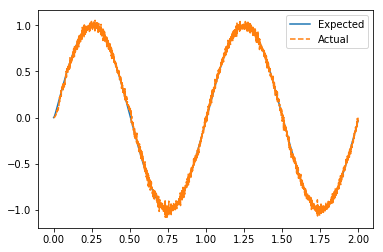

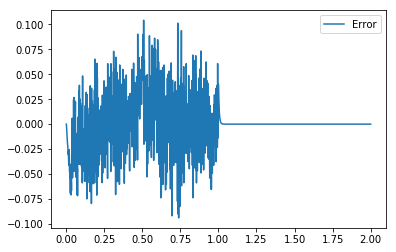

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sim.trange(), sim.data[p_u], label="Expected")
plt.plot(sim.trange(), sim.data[p_y], label="Actual", linestyle='--')
plt.legend()
plt.show()

plt.figure()
plt.plot(sim.trange(), sim.data[p_e], label="Error")
plt.legend()
plt.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


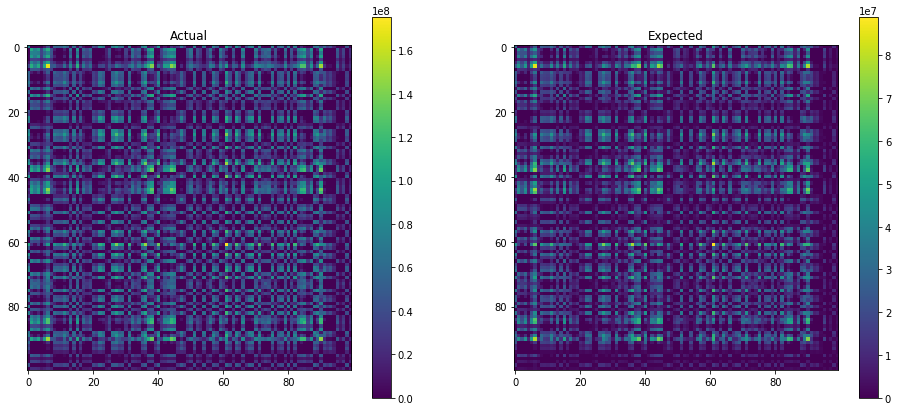

In [5]:
from scipy.linalg import inv

A = nengo.builder.ensemble.get_activities(
    sim.data[x], x, np.linspace(-1, 1, 1000)[:, None])
inv_gamma_expected = A.T.dot(A)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].set_title("Actual")
fig.colorbar(ax[0].imshow(inv(sim.data[p_P][-1])), ax=ax[0])
ax[1].set_title("Expected")
fig.colorbar(ax[1].imshow(inv_gamma_expected), ax=ax[1])
fig.show()
